In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torch.autograd import Variable
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import torch
import torch.optim as optim
import string
import time

# Training process on a small corpus

In [2]:
# Set parameters
context_size = 1
embed_size = 2
batch_size = 10
l_rate = 0.005
num_epochs = 20
log_iter = 10

### prepare the training data

In [3]:
# Open and read in text
text_file = open('story_short.txt', 'r')
text = text_file.read().lower()
text_file.close()

# Create vocabulary and word lists
word_list = word_tokenize(text.decode('utf-8'))
word_list = [''.join(c for c in s if c not in string.punctuation) for s in word_list]
word_list = [s for s in word_list if (s and s not in stopwords.words('english'))]


vocab = np.unique(word_list)
w_list_size = len(word_list)
vocab_size = len(vocab)

print('word list size:', w_list_size)
print('vocabulary size', vocab_size)

# Create word to index mapping
w_to_i = {word: ind for ind, word in enumerate(vocab)}
i_to_w = {ind: word for ind, word in enumerate(vocab)}

('word list size:', 2024)
('vocabulary size', 46)


In [4]:
# Construct co-occurence matrix
comat = np.zeros((vocab_size, vocab_size))
for i in range(w_list_size):
    for j in range(1, context_size+1):
        ind = w_to_i[word_list[i]]
        if i-j > 0:
            lind = w_to_i[word_list[i-j]]
            comat[ind, lind] += 1.0/j
        if i+j < w_list_size:
            rind = w_to_i[word_list[i+j]]
            comat[ind, rind] += 1.0/j

# Non-zero co-occurrences
coocs = np.transpose(np.nonzero(comat))

In [5]:
from numpy import unravel_index
first_k = np.dstack(np.unravel_index(np.argsort(comat.ravel())[-10:][::-1], (vocab_size, vocab_size)))[0]
print(first_k.shape)
word_list = []
for pair in first_k:
    print(i_to_w[pair[0]], i_to_w[pair[1]], comat[pair[0],pair[1]])
    word_list.append(i_to_w[pair[0]])
# print(w_to_i['sauce'])
# print(w_to_i['tomato'])
# print(i_to_w[247])
# 'insufficient','data'
# 'meaningful', 'answer'
# ''

(10, 2)
(u'iran', u'tehran', 44.0)
(u'russia', u'moscow', 44.0)
(u'japan', u'tokyo', 44.0)
(u'kabul', u'afghanistan', 44.0)
(u'france', u'paris', 44.0)
(u'baghdad', u'iraq', 44.0)
(u'england', u'london', 44.0)
(u'afghanistan', u'kabul', 44.0)
(u'london', u'england', 44.0)
(u'madrid', u'spain', 44.0)


### define function

In [6]:
alpha = 0.75
xmax = 100
# Weight function
def wf(x):
    if x < xmax:
        return (x/xmax)**alpha
    return 1

# Set up word vectors and biases
l_embed, r_embed = [
    [Variable(torch.from_numpy(np.random.normal(0, 0.01, (embed_size, 1))),
        requires_grad = True) for j in range(vocab_size)] for i in range(2)]
l_biases, r_biases = [
    [Variable(torch.from_numpy(np.random.normal(0, 0.01, 1)), 
        requires_grad = True) for j in range(vocab_size)] for i in range(2)]

# Set up optimizer
optimizer = optim.Adam(l_embed + r_embed + l_biases + r_biases, lr = l_rate)

# Batch sampling function
def gen_batch():
    sample = np.random.choice(np.arange(len(coocs)), size=batch_size, replace=False)
    l_vecs, r_vecs, covals, l_v_bias, r_v_bias = [], [], [], [], []
    for chosen in sample:
        ind = tuple(coocs[chosen])
        l_vecs.append(l_embed[ind[0]])
        r_vecs.append(r_embed[ind[1]])
        covals.append(comat[ind])
        l_v_bias.append(l_biases[ind[0]])
        r_v_bias.append(r_biases[ind[1]])
    return l_vecs, r_vecs, covals, l_v_bias, r_v_bias

# Visualize embeddings
def display_vector(word_inds, ax, fig):
    ax.clear()
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    if embed_size == 2:
        # Pick some random words
        for word_ind in word_inds:
            # Create embedding by summing left and right embeddings
            w_embed = (l_embed[word_ind].data + r_embed[word_ind].data).numpy()
            x, y = w_embed[0][0], w_embed[1][0]
            ax.scatter(x, y)
            ax.annotate(vocab[word_ind], xy=(x, y), xytext=(8, 2),
                textcoords='offset points', ha='right', va='bottom')
            
        fig.canvas.draw()

### training and plotting

<IPython.core.display.Javascript object>


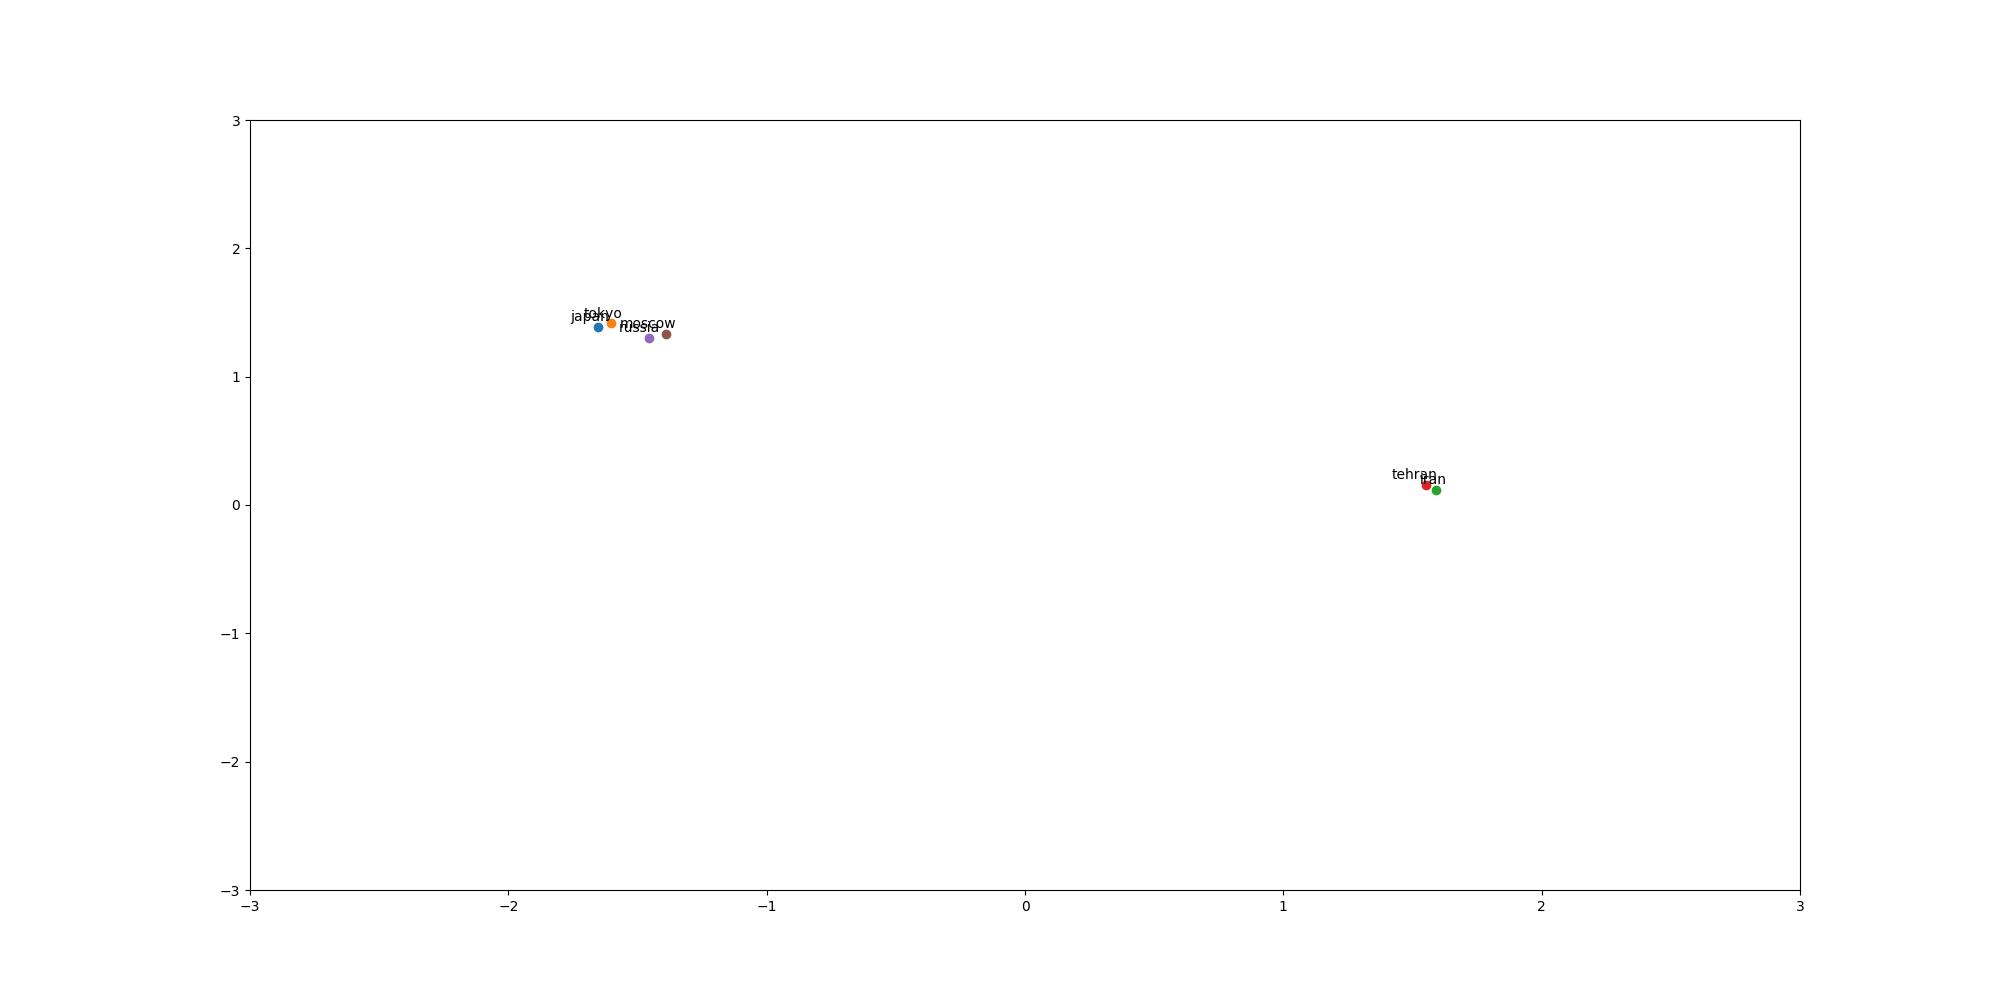

Epoch [0/20], Iteration [201/202], Loss: 3.3869
Epoch [1/20], Iteration [201/202], Loss: 2.4678
Epoch [2/20], Iteration [201/202], Loss: 2.1046
Epoch [3/20], Iteration [201/202], Loss: 1.8791
Epoch [4/20], Iteration [201/202], Loss: 1.2968
Epoch [5/20], Iteration [201/202], Loss: 1.9846
Epoch [6/20], Iteration [201/202], Loss: 1.3102
Epoch [7/20], Iteration [201/202], Loss: 1.4087
Epoch [8/20], Iteration [201/202], Loss: 1.4995
Epoch [9/20], Iteration [201/202], Loss: 1.3827
Epoch [10/20], Iteration [201/202], Loss: 1.4209
Epoch [11/20], Iteration [201/202], Loss: 1.4646
Epoch [12/20], Iteration [201/202], Loss: 1.3260
Epoch [13/20], Iteration [201/202], Loss: 1.1673
Epoch [14/20], Iteration [201/202], Loss: 1.2467
Epoch [15/20], Iteration [201/202], Loss: 1.2628
Epoch [16/20], Iteration [201/202], Loss: 1.0742
Epoch [17/20], Iteration [201/202], Loss: 1.1013
Epoch [18/20], Iteration [201/202], Loss: 1.0512
Epoch [19/20], Iteration [201/202], Loss: 0.9760


In [7]:
# Train model

word_list = ['japan', 'tokyo', 'iran', 'tehran', 'russia', 'moscow']
word_inds = [w_to_i[word] for word in word_list]

fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])

plt.ion()

fig.show()
fig.canvas.draw()

for epoch in range(num_epochs):
    num_batches = int(w_list_size/batch_size)
    avg_loss = 0.0
    for batch in range(num_batches):
        optimizer.zero_grad()
        l_vecs, r_vecs, covals, l_v_bias, r_v_bias = gen_batch()
        loss = sum([torch.mul( ( torch.dot(l_vecs[i].view(-1), r_vecs[i].view(-1)) +
                l_v_bias[i] + r_v_bias[i] - np.log(covals[i]) )**2,
                wf(covals[i]) ) for i in range(batch_size)])
        avg_loss += loss.data[0]/num_batches
        loss.backward()
        optimizer.step()
    if batch % 1 == 0:
        print('Epoch [%d/%d], Iteration [%d/%d], Loss: %.4f'
              %(epoch, num_epochs, batch, num_batches, avg_loss)) 
        display_vector(word_inds, ax0, fig)
        time.sleep(0.5)

# Show result with trained vectors

In [8]:
import torch
import torchtext.vocab as vocab

glove = vocab.GloVe(name='6B', dim=100)

print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


In [9]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

def closest(vec, n=10):
    """
    Find the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in glove.itos]
    return sorted(all_dists, key=lambda t: t[1])[:n]

def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))
        
def analogy(w1, w2, w3, n=5, filter_given=True):
    print('\n[%s : %s :: %s : ?]' % (w1, w2, w3))
   
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word(w2) - get_word(w1) + get_word(w3))
    
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

### Find closest words to 'Facebook'

In [10]:
print_tuples(closest(get_word('facebook')))

(0.0000) facebook
(2.3692) twitter
(2.6370) myspace
(3.5014) youtube
(4.1165) google
(4.1728) blog
(4.2519) linkedin
(4.2810) web
(4.3965) website
(4.4423) tumblr


### Facebook to Tencent is like Google to ??

$w(?) = w('google') - w('facebook') + w('tencent')$

In [11]:
analogy('facebook', 'tencent', 'google')


[facebook : tencent :: google : ?]
(4.5830) baidu
(5.1494) baidu.com
(5.2040) baike
(5.2198) heublein
(5.2547) alienware
